In [2]:
from pymaxed.maxed import Maxed
from pymaxed.vectors import Vec
from pymaxed.pdfs import bi_normal_ref_1
from pyapes.core.mesh import Mesh
from pyapes.core.geometry import Box, Cylinder

# The Maximum Entropy Distribution problem

Given is a set of moments $\vec{m}$ the entropy constraints of the Maximum Entropy distribution in the phase space $\vec{u}$.

For the given problem, we'd like to reconstruct the distribution

$$
f^{MED}_{\vec{\lambda}} := exp(\vec{\lambda}\cdot\Phi(\vec{u}))
$$.

This can be achieved by solving the unconstrained minimization problem:

$$
\vec{\lambda}(\vec{m}) = \text{argmin} \left\{\int \exp{(\vec{\tilde{\lambda}} \cdot \Phi(\vec{u}))} d\vec{u} - \vec{\tilde{\lambda}}\cdot \vec{m}\right\}.
$$

## Numerical implementation
### 1D PDF reconstruction

Assume we have the set of moment $\vec{m} = [1, 0, 1, -0.27, 1.7178]^T$ in the 1D phase space. This set of moment implies reconstruction of the MaxEd using the moment up to an order of 4.

Using `pymaxed` package, above mathematical problem reads


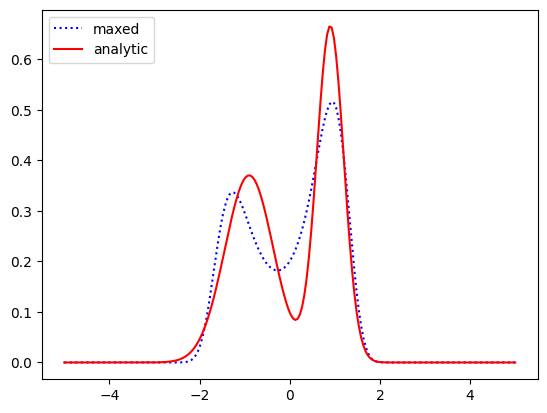

In [4]:
target = [1, 0, 1, -0.27, 1.7178] # target moments set. Can be either list of float or Tensor
mesh = Mesh(Box[-5:5], None, [200]) # Phase space. For the cartensian mesh, use the Box geometry. For the cylindrical mesh, use the Cylinder geometry
vec = Vec(mesh, target, 4, [200]) # Construct the vector spaces for the polynomial basis

maxed = Maxed(vec) # Construct the MaxEd object

maxed.solve() # Solve for the gamma
import matplotlib.pyplot as plt
analytic = bi_normal_ref_1(mnts_order=4, m=0.9, s=0.3, bound=5, n_vel=200)


_, ax = plt.subplots(1, 1)
plt.plot(vec.dv[0], maxed.dist, "b:", label="maxed")
plt.plot(vec.dv[0], analytic["pdf"], "r-", label="analytic")
plt.legend(loc="upper left")

### 2D axisymmetric PDF reconstruction

The axisymmetric implementation can be achieved by using `pyapes.core.gemetry.Cylinder` class in `pymaxed.vector.Vec` class.

Below example is utilizing the target set of moments which is the same as above in the vertical direction while the radial direction maintains the Gaussian distribution.

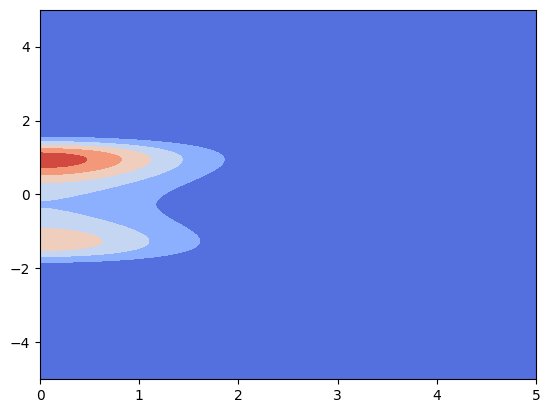

In [9]:
target = [1, 0, 1, -0.27, 1.7178, 2, 8, 0, 2]
mesh = Mesh(Cylinder[0:5, -5:5], None, [128, 256])

vec = Vec(mesh, target, 4, [50, 100])
maxed = Maxed(vec)

maxed.solve()
_, ax = plt.subplots(1, 1)
plt.contourf(vec.dv[0], vec.dv[1], maxed.dist, cmap="coolwarm")


### Cost and Accuracy

If we increase the total number of moments to constrain the PDF, it is expected to have more accurate approximation.

However, due to the increase of the number of unknowns, the computational cost will be increase as well.

Therefore, it is worth to check the cost of the optimization process against its accuracy so that can have the optimal number of moments.

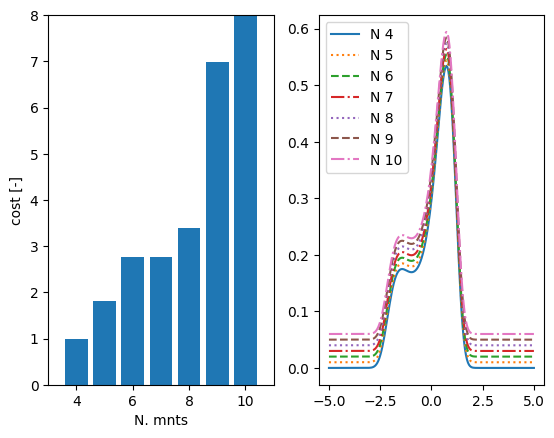

In [12]:
import time
import torch

# Number of total moments to be tested
order_set = [4, 5, 6, 7, 8, 9, 10]
linstyles = ["-", ":", "--", "-.", ":", "--", "-."]
elapsed_time = []
acc_norm = []
pdfs = []
x = []

for o in order_set:
    target = bi_normal_ref_1(o, m=0.8, s=0.3, bound=5, n_vel=200)
    mesh = Mesh(Box[-5:5], None, [200])
    vec = Vec(mesh, target["mnts"], o, [200])
    maxed = Maxed(vec)
    tic = time.perf_counter()
    maxed.solve()
    elapsed_time.append(time.perf_counter() - tic)
    t_tensor = torch.tensor(
        target["mnts"], device=mesh.device, dtype=mesh.dtype.float
    )
    obtained = maxed.mnts_computed
    acc_norm.append(torch.linalg.norm(t_tensor - obtained))
    pdfs.append(maxed.dist)
    x = vec.dv[0]

_, ax = plt.subplots(1, 2)
cost_4 = elapsed_time[0]
cost = [c / cost_4 for c in elapsed_time]
ax[0].bar(order_set, cost)
ax[0].set_ylim(0, 8)
ax[0].set_xlim(3, 11)
ax[0].set_xlabel("N. mnts")
ax[0].set_ylabel("cost [-]")

for idx, (o, l) in enumerate(zip(order_set, linstyles)):
    ax[1].plot(x, pdfs[0]+0.01*idx, label=f"N {o}", linestyle=l)
ax[1].legend(loc="upper left")